In [1]:
# import library
# ========= choice of library ====
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [108]:
# Get the certain STL 10 Data
from skimage import util 
data_location = "../../Dataset/STL10/img/2/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))

image_resize_px = 64
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index],mode='L'),(image_resize_px,image_resize_px))

# print out the data shape and the max and min value
train_batch = np.expand_dims(train_batch,3)
print('Train batch, min, max : ',train_batch.shape,train_batch.min(),train_batch.max())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Train batch, min, max :  (500, 64, 64, 1) 0.0 1.0


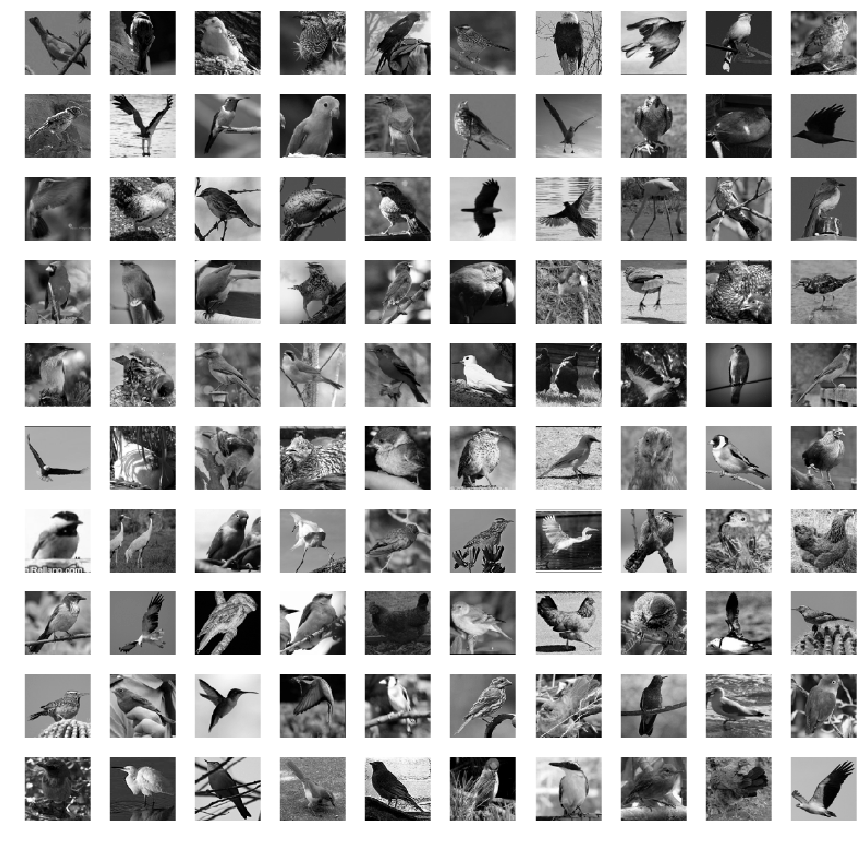

In [109]:
# view random 100 images
idx = np.random.permutation(len(train_batch))
train_batch = train_batch[idx]
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
plt.show()

In [145]:
# import all of the needed layers and activation layer
# ======= Activation Function  ==========
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)
def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)
def tf_tanh(x): return tf.tanh(x)
def d_tf_tanh(x): return 1.0 - tf_tanh(x) ** 2

class CNN():

    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='SAME',l2_reg = False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        )

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))

        return grad_pass,update_w

class FNN():
    """Fully Connected Neural Network Implemented in Tensorflow

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.
    special_init : type
        Description of parameter `special_init`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act,special_init=False):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w  = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float64,seed=4))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient=None,l2_regularization=False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        if l2_regularization:
            grad = grad + lamda * self.w

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        return grad_pass,update_w    

class FastICA_Layer():
    """Performs ICA via FastICA method

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    sym_decorrelation : type
        Description of attribute `sym_decorrelation`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    self,matrix : type
        Description of attribute `self,matrix`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.005,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act

    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)

    def getw(self): return self.w

    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer

    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_pass = tf.matmul(tf.transpose(self.w),self.layer)
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA[:,tf.newaxis] * self.w
        grad_w_dec = self.sym_decorrelation(grad_w)
        update_w = []
        update_w.append(tf.assign(self.w,grad_w_dec))
        return grad_pass,update_w
    
class ICA_Layer():
    """Perform Independent component analysis via gradient ascent method
    see: http://www.sci.utah.edu/~shireen/pdfs/tutorials/Elhabian_ICA09.pdf

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    self,input : type
        Description of attribute `self,input`.
    act
    d_act

    """

    def __init__(self,inc,act,d_act):
        self.w = tf.Variable(tf.random_normal([inc,inc],stddev=0.05,seed=2,dtype=tf.float64))
        self.m = tf.Variable(tf.zeros_like(self.w));self.v = tf.Variable(tf.zeros_like(self.w));
        self.act = act; self.d_act = d_act
    def getw(self): return self.w
    
    def feedforward(self,input):
        self.input = input
        self.ica_est = tf.matmul(input,self.w)
        self.ica_est_act = self.act(self.ica_est)
        return self.ica_est_act

    def backprop(self):
        grad_part_2 = self.d_act(self.ica_est)
        grad_part_3 = self.input

        grad_pass = tf.matmul(grad_part_2,tf.transpose(self.w))
        grad_sum_1 = tf.expand_dims(tf.reduce_sum(tf.transpose(self.input),1),1) / batch_size
        grad_sum_2 = tf.expand_dims(tf.reduce_sum(self.ica_est_act,0),0) / batch_size
        grad = tf.linalg.inv(tf.transpose(self.w)) - (2.0/batch_size) * tf.matmul(grad_sum_1,grad_sum_2)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,self.w+adam_middle))
        return grad_pass,update_w

In [177]:
# define hyper, class and graph
num_epcoch = 800 ; lea8rning_rate = 0.0008; print_size = 10
batch_size = 100
beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = CNN(3,1,3)
l2 = CNN(3,3,3)
l3 = CNN(3,3,3)
# l_ica = FastICA_Layer(50, 100,act=tf_logcosh,d_act=d_tf_logcosh)
l_ica = ICA_Layer(100,act=tf_tanh,d_act=d_tf_tanh)

x = tf.placeholder(shape=[batch_size,64,64,1],dtype=tf.float64)
layer1 = l1.feedforward(x)
layer1_pool = tf.nn.avg_pool(layer1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
layer2 = l2.feedforward(layer1_pool)
layer3 = l3.feedforward(layer2)
layer3_flat = tf.reshape(layer3,[batch_size,-1])
layer_ica = l_ica.feedforward(tf.transpose(layer3_flat))

just_mean = tf.reduce_mean(layer_ica)

grad_ica,grad_ica_u = l_ica.backprop()
grad_ica_reshape = tf.reshape(tf.transpose(grad_ica),[batch_size,32,32,3])
grad_3,grad_3_up = l3.backprop(grad_ica_reshape)
grad_2,grad_2_up = l2.backprop(grad_3)
grad_2_uppooling = tf.tile(grad_2,[1,2,2,1])
grad_1,grad_1_up = l1.backprop(grad_2_uppooling)

grad_update = grad_ica_u + grad_3_up + grad_2_up + grad_1_up

In [ ]:
# start the interactive session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for iter in range(num_epcoch):
    train_batch = shuffle(train_batch)
    for current_batch_index in range(0,len(train_batch),batch_size):
        current_data = train_batch[current_batch_index:current_batch_index+batch_size]
        sess_results = sess.run([just_mean,grad_update],feed_dict={x:current_data})
        print('iter: ',iter,' index: ', current_batch_index,' mean ',sess_results[0],end='\r')
        
    if iter > 0 and iter % print_size == 0 :
        print('\n------------\n')

iter:  10  index:  400  mean  0.01229286551779766265-0.010279566771290159
------------

iter:  20  index:  400  mean  0.003288132169986514525
------------

iter:  30  index:  400  mean  0.004241076999916823265
------------

iter:  40  index:  400  mean  -0.01259442554764839508  index:  0  mean  0.0029330370920401783  mean  0.0031463845804482883
------------

iter:  50  index:  400  mean  -0.00040393360312833415
------------

iter:  60  index:  400  mean  -0.004072736842432340440.00678134878201270258  index:  100  mean  -0.014354964814100892
------------

iter:  70  index:  400  mean  -0.0068697885647821865
------------

iter:  80  index:  400  mean  0.00463911642520688294
------------

iter:  90  index:  400  mean  0.00078595777084156463 mean  -0.00276292561787977
------------

iter:  100  index:  400  mean  -0.0113590685259189917mean  0.008001951811220234
------------

iter:  110  index:  400  mean  0.006969062809334271912
------------



In [ ]:
# get the session results
sess_results = sess.run([layer_ica,layer3,layer2,layer1],feed_dict={x:current_data})
for x in sess_results:
    print(x.shape)

In [ ]:
temp  = sess_results[0].T.reshape(100,32,32,3)
temp1 = sess_results[1]
temp2 = sess_results[2]
temp3 = sess_results[3]
# Normal each channel
temp[:,:,:,0] = (temp[:,:,:,0]-temp[:,:,:,0].min())/(temp[:,:,:,0].max()-temp[:,:,:,0].min())
temp[:,:,:,1] = (temp[:,:,:,1]-temp[:,:,:,1].min())/(temp[:,:,:,1].max()-temp[:,:,:,1].min())
temp[:,:,:,2] = (temp[:,:,:,2]-temp[:,:,:,2].min())/(temp[:,:,:,2].max()-temp[:,:,:,2].min())

temp1[:,:,:,0] = (temp1[:,:,:,0]-temp1[:,:,:,0].min())/(temp1[:,:,:,0].max()-temp1[:,:,:,0].min())
temp1[:,:,:,1] = (temp1[:,:,:,1]-temp1[:,:,:,1].min())/(temp1[:,:,:,1].max()-temp1[:,:,:,1].min())
temp1[:,:,:,2] = (temp1[:,:,:,2]-temp1[:,:,:,2].min())/(temp1[:,:,:,2].max()-temp1[:,:,:,2].min())

temp2[:,:,:,0] = (temp2[:,:,:,0]-temp2[:,:,:,0].min())/(temp2[:,:,:,0].max()-temp2[:,:,:,0].min())
temp2[:,:,:,1] = (temp2[:,:,:,1]-temp2[:,:,:,1].min())/(temp2[:,:,:,1].max()-temp2[:,:,:,1].min())
temp2[:,:,:,2] = (temp2[:,:,:,2]-temp2[:,:,:,2].min())/(temp2[:,:,:,2].max()-temp2[:,:,:,2].min())

temp3[:,:,:,0] = (temp3[:,:,:,0]-temp3[:,:,:,0].min())/(temp3[:,:,:,0].max()-temp3[:,:,:,0].min())
temp3[:,:,:,1] = (temp3[:,:,:,1]-temp3[:,:,:,1].min())/(temp3[:,:,:,1].max()-temp3[:,:,:,1].min())
temp3[:,:,:,2] = (temp3[:,:,:,2]-temp3[:,:,:,2].min())/(temp3[:,:,:,2].max()-temp3[:,:,:,2].min())

In [ ]:
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(temp[i-1])
    except:
        pass
    plt.axis('off')
plt.suptitle('ICA Layer')
plt.show()
plt.close('all')

fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(temp1[i-1])
    plt.axis('off')
plt.suptitle('Layer 3')
plt.show()
plt.close('all')

fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(temp2[i-1])
    plt.axis('off')
plt.suptitle('Layer 2')
plt.show()
plt.close('all')

fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(temp3[i-1])
    plt.axis('off')
plt.suptitle('Layer 1')
plt.show()
plt.close('all')

fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(current_data[i-1]))
    plt.axis('off')
plt.suptitle('Original Image')
plt.show()
plt.close('all')


In [ ]:
! git all-go

In [3]:
! start .